In [14]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
#backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.visualization import array_to_latex
from scipy.stats import unitary_group

In [81]:
#OTOC
#PLUS PART

def circ_plus_rand(n,layers,pos):
   
  
    qc0 = QuantumCircuit(n)
    qc = QuantumCircuit(n)
    #V_i perturbation -pi/2
    qc0.ry((+np.pi/2),n//2,label='V_plus')
    #random fwd evolution
    qc.barrier(range(n))
    qc.barrier(range(n))
    qc=qc.compose(randbwassembler(layers,n))
    qcc = QuantumCircuit(n)
    #W perturbation
    qcc.z(pos)
    #random backwards evolution
    qcc = qcc.compose(qc.inverse())
    circ = QuantumCircuit(n)
    circ = qc0.compose(qc.compose(qcc))
    
    return circ




def circ_minus_rand(n,layers,pos):
    
    
    qc0 = QuantumCircuit(n)
    qc = QuantumCircuit(n)
    #V_i perturbation -pi/2
    qc0.ry((-np.pi/2),n//2,label='V_minus')
    #random fwd evolution
    qc.barrier(range(n))
    qc.barrier(range(n))
    qc=qc.compose(randbwassembler(layers,n))
    qcc = QuantumCircuit(n)
    #W perturbation
    qcc.z(pos)
    #random backwards evolution
    qcc = qcc.compose(qc.inverse())
    circ = QuantumCircuit(n)
    circ = qc0.compose(qc.compose(qcc))
    
    
    return circ
   

#define unitary
def U(A,T,G):
    U = np.zeros((4,4), dtype=complex)
    
    U[0,0]=(-1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[0,3]=(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,1]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,2]=(-1+2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,1]=(-1-2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,2]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,0]=-(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,3]=(1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    return(U)

def Ureal(A,T,G):
    
    Ur = np.zeros((4,4), dtype=complex)
    
    coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**2)+(1/np.cosh(T/2)**2)))
    
    coef2=np.sqrt(2*A**(2)*(np.cosh(G)+np.cosh(T))+np.sinh(T)**2)
    
    
    Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    Ur[0,3]=(2*A*np.sinh(T/2))/coef2
    
    Ur[1,1]=(2*A*np.cosh(T/2))/coef2
    
    Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,2]=(2*A*np.cosh(T/2))/coef2
    
    Ur[3,0]=-(2*A*np.sinh(T/2))/coef2
    
    Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    return(Ur)
#define random BW
def randbwassembler(layers,n):
    qc = QuantumCircuit(n)
    m=0
    while m < layers:
        i=0;j=0;    
        
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(unitary_group.rvs(4),[2*j+1,0])
            else:
                qc.unitary(unitary_group.rvs(4), [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        #even layer
        while i < n/2:
            qc.unitary(unitary_group.rvs(4), [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n))
        
        
        m+=1
    qc.barrier(range(n))
    return(qc)

#define operators to measure
def generate_pauli(n, j):
    if n <= 0 or j < 0 or  j >= n:
        raise ValueError("Invalid input values")
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i and j
    pauli_str_list = list(pauli_str)
    pauli_str_list[j] = "X"
    pauli_str = "".join(pauli_str_list)
    op = SparsePauliOp(pauli_str, coeffs=[1])
    
    return op

def prodstaten(n):
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]+1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator
    
def bell_pair1(qc, a, b):
    
    qc.h(a) # Put qubit a into state |+> or |-> using hadamard gate
    qc.cx(a,b) # CNOT with a as control and b as target
    
def bell_pair4(qc,a,b):
    
    qc.h(a)
    qc.x(b)
    qc.z(a)
    qc.z(b)
    qc.cx(a,b)

In [5]:
mat=U(1,1,1)
uni = mat.conj().T@mat
np.allclose(np.eye(4),uni,atol=1e-15)

True

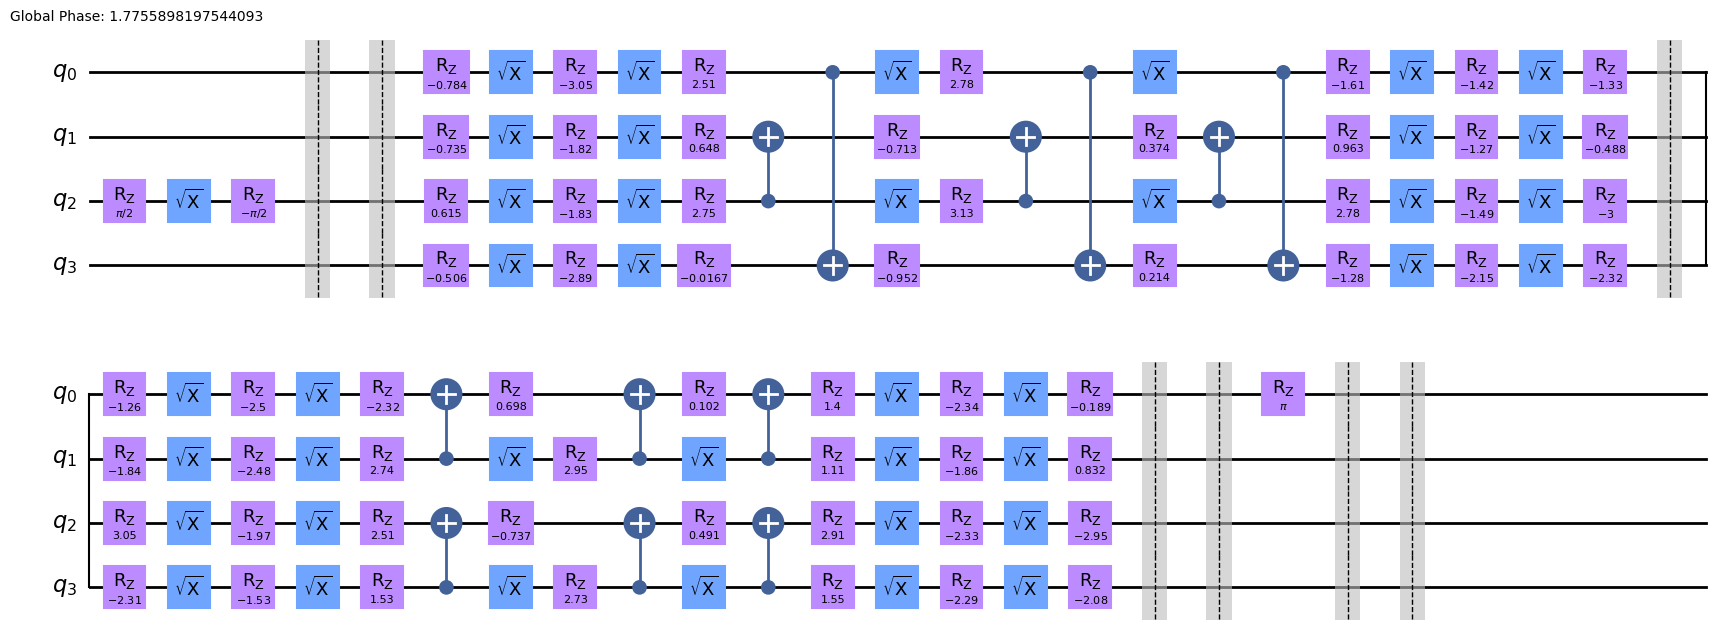

In [20]:
dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

In [58]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b58a80862cd6d4e3f8618d0fb10c85a7415315bcf55dd407e498ce33bdd4709623e266b4fdee952700733135cd2fa847c7bffa65966a4efb0aa2ae6a4ad7b583", overwrite=True)

In [101]:
#MAIN (TROTTER) RANDOM CIRC

#parameters
n=6
time=6
layers = np.array([j for j in range(1,time)])
C = np.zeros((n,len(layers)),dtype=float)
init='0'*n


#specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")

#settings job execution
options = Options()
options.execution.shots = 20000
options.optimization_level = 1  # optimization
options.resilience_level = 1  # mitigation

for i in tqdm(range(0,n)):
    for k,j in enumerate(tqdm(layers)):
        qcp=QuantumCircuit(n)
        qcm=QuantumCircuit(n)
        #init
        string = init
        QuantumCircuit.initialize(qcp,string)
        QuantumCircuit.initialize(qcm,string)
        qcp=qcp.compose(circ_plus_rand(n,j,i))
        qcm=qcm.compose(circ_minus_rand(n,j,i))
        #transpiling
        basis_gates=['cx', 'id', 'rz', 'x', 'sx']
        qcp=transpile(qcp, basis_gates=basis_gates, optimization_level=1)
        qcm=transpile(qcm, basis_gates=basis_gates, optimization_level=1)
        
        #generate operator to measure
        op=generate_pauli(n,n//2)
        #runtime plus
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[qcp], observables=[op])
            values_plus = job_sim.result().values
        #runtime minus
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[qcm], observables=[op])
            values_minus = job_sim.result().values
        Corr = 2 + values_minus - values_plus
        C[i,k]=Corr

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:10<00:00, 51.82s/it]


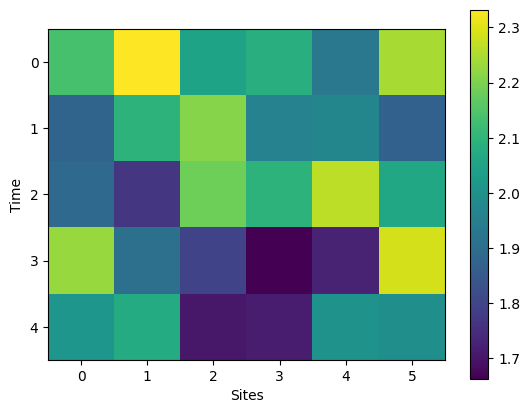

In [102]:
Cnew=np.flipud(np.transpose(C))
plt.imshow(Cnew)
plt.xlabel('Sites')
plt.ylabel('Time')
#plt.title('A='+str(A)+' T='+str(T)+' G='+str(G)+' size='+str(n)+' init='+str(init)+' step='+str(step))
plt.colorbar()


In [69]:
#MAIN 2 THE ONE THAT IS GONNA WORK (THETA SWEEP) RANDOM CIRC
#theta0*layers=t
#parameters
n,A,T,G,step=6,1,1,0,1
times = [j for j in range(1,5)]
theta0=0.01
thetas= np.arange(0.001,2,0.1)
C = np.zeros((n,len(thetas)),dtype=float)
init='000000'

#specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")

#settings job execution
options = Options()
options.execution.shots = 1000
options.optimization_level = 1  # optimization
options.resilience_level = 1  # mitigation

for i in tqdm(range(0,n)):
    for k,t in enumerate(tqdm(thetas)):
        
        qc = QuantumCircuit(n)
        #layers=round(t/theta0)
        trans_plus=circ_plus_rand(qc,n,1,i) #qc,n,layer,pos
        trans_minus=circ_minus_rand(qc,n,1,i)
        
        
        #generate operator to measure
        op=generate_pauli(n,n//2)
        #runtime plus
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[trans_plus], observables=[op])
            values_plus = job_sim.result().values
        #runtime minus
        with Session(service=service, backend=backend) as session:
            estimator_sim = Estimator(session=session, options=options)
            job_sim = estimator_sim.run(circuits=[trans_minus], observables=[op])
            values_minus = job_sim.result().values
        Corr = 2 + values_minus - values_plus
        C[i,k]=Corr

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:04<00:00,  9.22s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:50<00:00,  8.55s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [19:02<00:00, 190.43s/it]


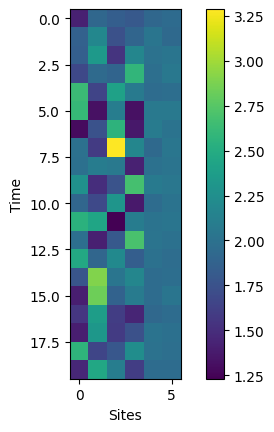

In [70]:
Cnew=np.flipud(np.transpose(C))
plt.imshow(Cnew)
plt.xlabel('Sites')
plt.ylabel('Time')
#plt.title('A='+str(A)+' T='+str(T)+' G='+str(G)+' size='+str(n)+' init='+str(init)+' step='+str(step))
plt.colorbar()

In [ ]:
#saving data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n='+str(n)+' init: '+str(string), 'wb') as file:
      
    # A new file will be created
    pickle.dump(ent_entropy, file)

In [ ]:
#loading data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n=10', 'rb') as file:
    loaded_data = pickle.load(file)

## Reversibility of circuit test

In [82]:
generate_pauli(6,6//2)

SparsePauliOp(['IIIXII'],
              coeffs=[1.+0.j])

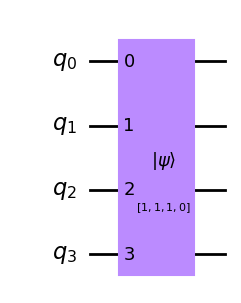

In [108]:
n=4
layers=1
matrix=U(1,1,1)
qc=QuantumCircuit(n)
string = "1110" 
QuantumCircuit.initialize(qc,string)
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')


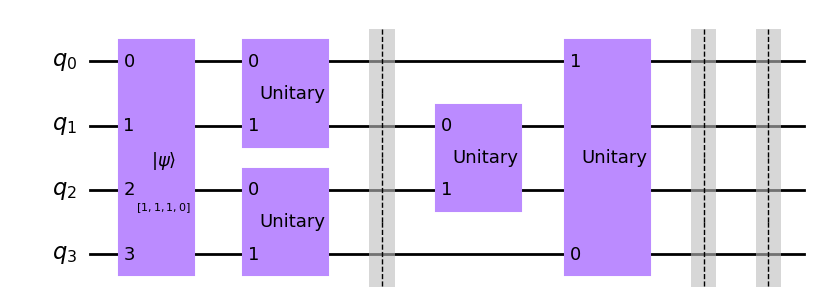

In [109]:
qc.compose(bwassembler(qc,matrix,layers,n))
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')


In [ ]:
qc.compose(revbwassembler(qc,matrix,layers,n))
qc.draw(out

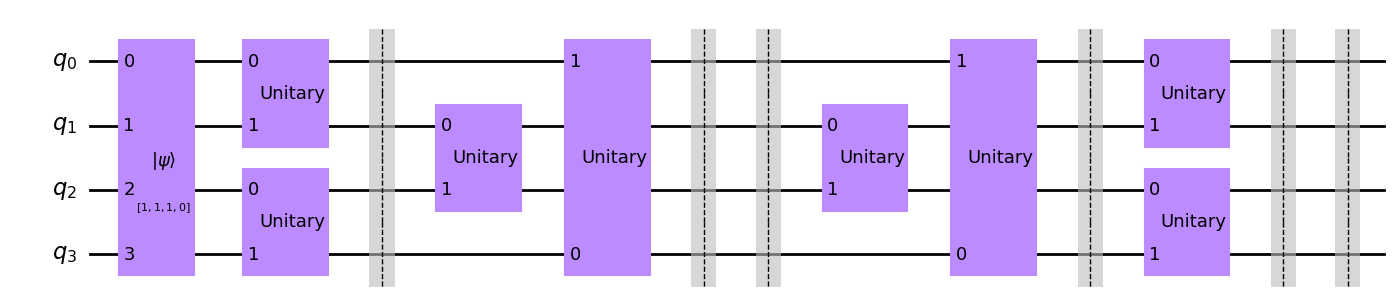

In [110]:
qc.compose(revbwassembler(qc,matrix,layers,n))
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

<IPython.core.display.Latex object>

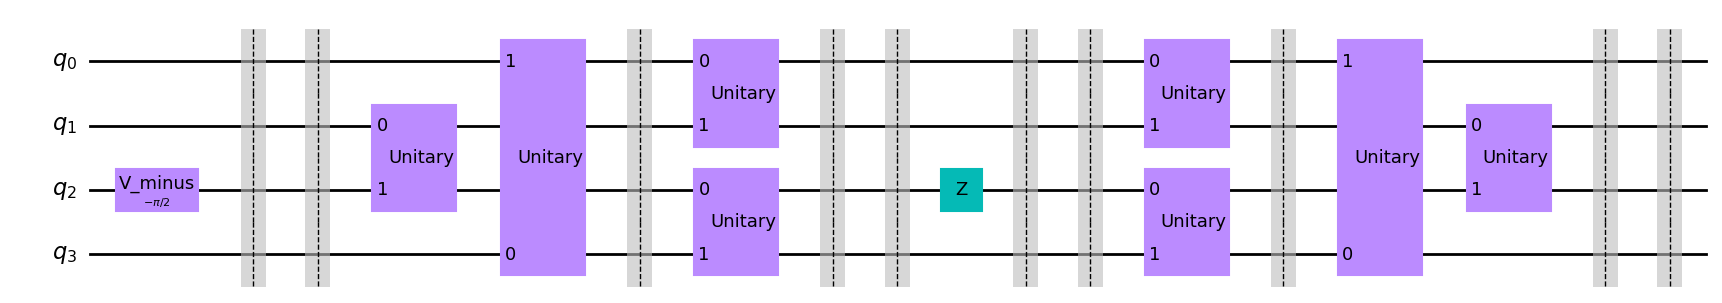

In [67]:
n=4;i=2
qc0 = QuantumCircuit(n)
qc = QuantumCircuit(n)
#V_i perturbation -pi/2
qc0.ry((-np.pi/2),n//2,label='V_minus')
#random fwd evolution
qc.barrier(range(n))
qc.barrier(range(n))
qc=qc.compose(randbwassembler(1,4))
qcc = QuantumCircuit(n)
#W perturbation
qcc.z(i)
#qcc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')
#backwards evolution
qcc = qcc.compose(qc.inverse())
circ = QuantumCircuit(n)
circ = qc0.compose(qc.compose(qcc))
#transpiling 
#basis_gates=['cx', 'id', 'rz', 'x', 'sx']
#qc=transpile(qc,basis_gates=basis_gates, optimization_level=1)
circ.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

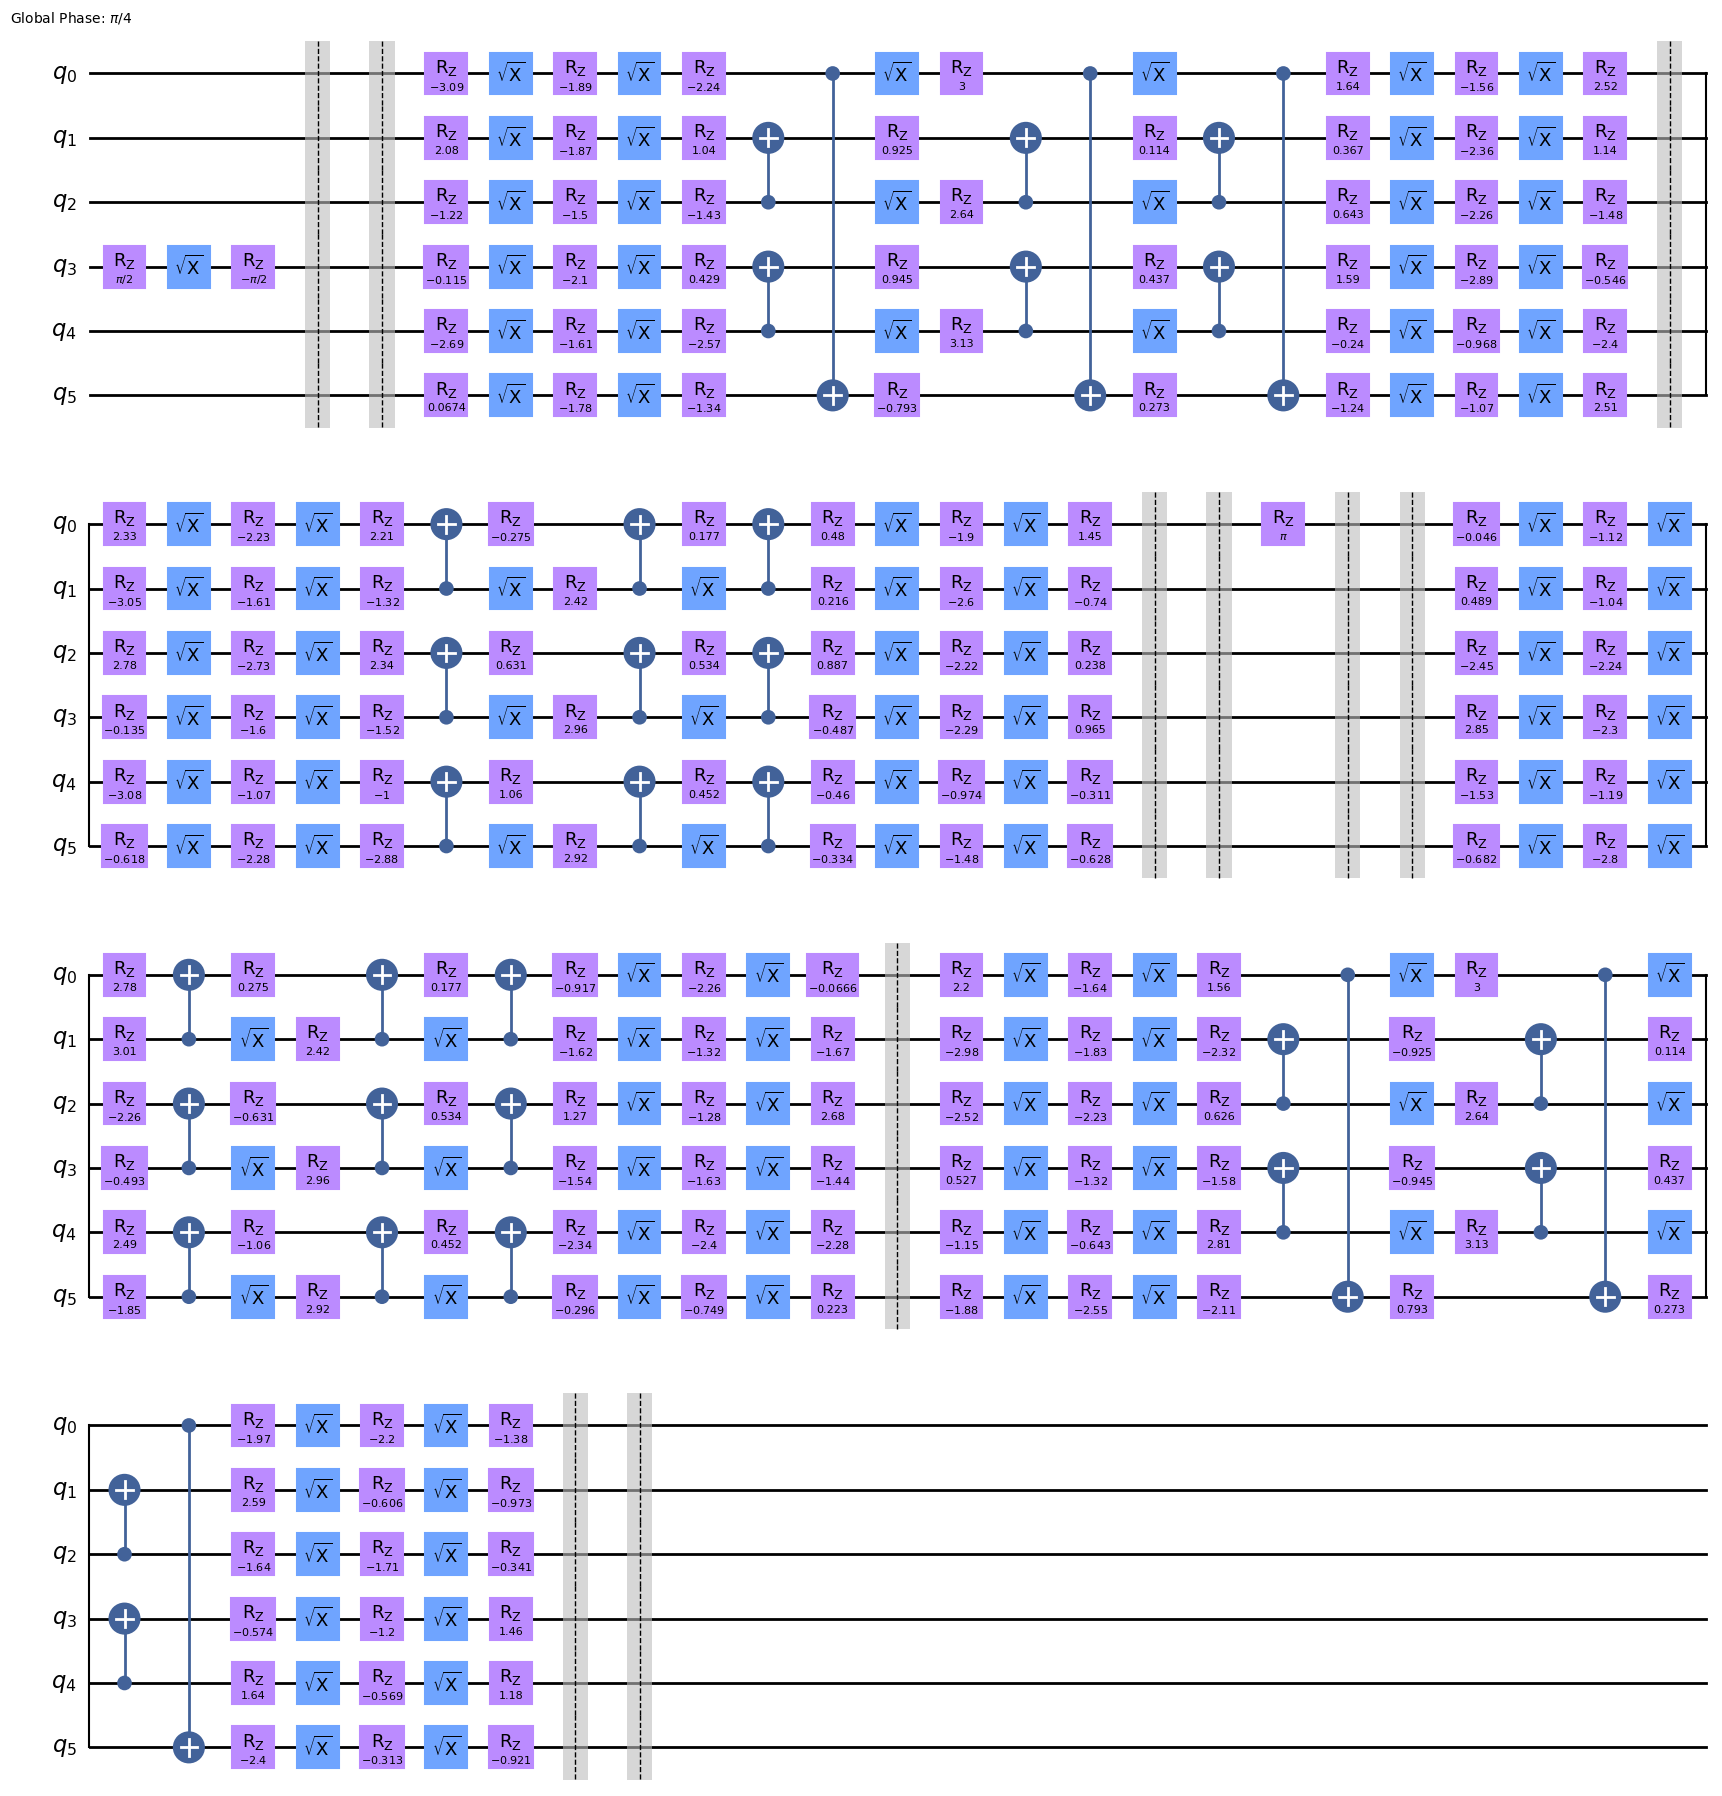

In [93]:
n=6
qcp=QuantumCircuit(n)
qcm=QuantumCircuit(n)
#init
string = init
QuantumCircuit.initialize(qcp,string)
QuantumCircuit.initialize(qcm,string)
qcp=qcp.compose(circ_plus_rand(n,j,i))
qcm=qcm.compose(circ_minus_rand(n,j,i))
#transpiling
basis_gates=['cx', 'id', 'rz', 'x', 'sx']
qcp=transpile(qcp, basis_gates=basis_gates, optimization_level=1)
qcm=transpile(qcm, basis_gates=basis_gates, optimization_level=1)
qcm.draw(output='mpl',style={'displaycolor':dispcolors})
#generate operator to measure
#op=generate_pauli(n,n//2)
##runtime plus
#with Session(service=service, backend=backend) as session:
#    estimator_sim = Estimator(session=session, options=options)
#    job_sim = estimator_sim.run(circuits=[qcp], observables=[op])
#    values_plus = job_sim.result().values

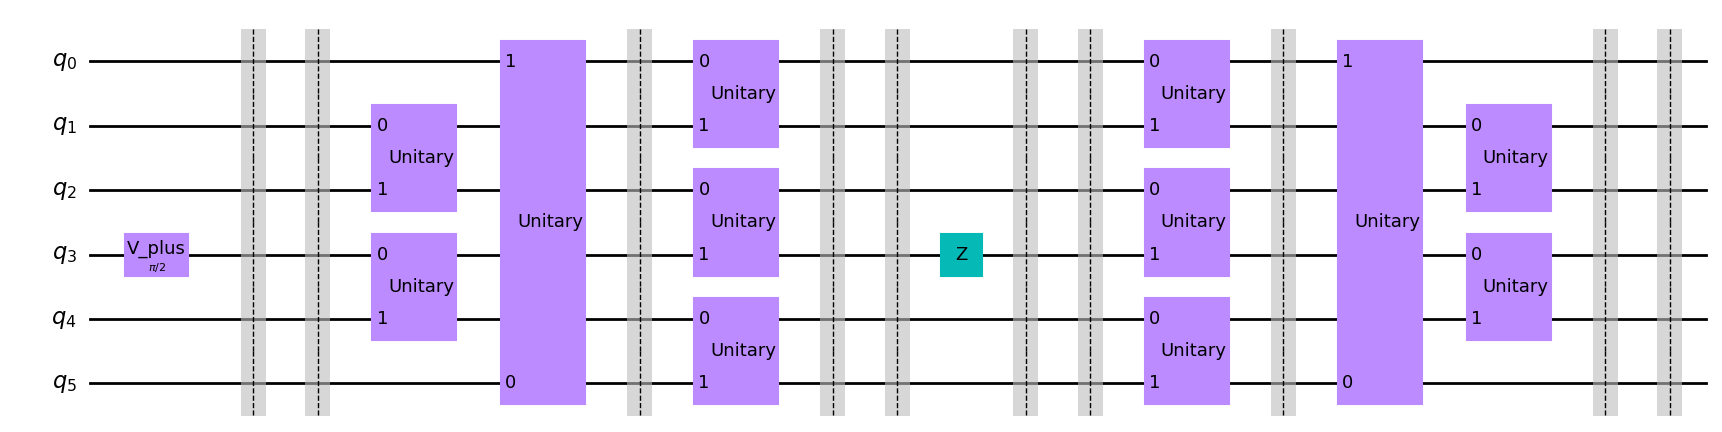